In [1]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

### 1.データの読み込み

In [2]:
df = pd.read_csv('stock_price.csv')
df

,日付け,終値,始値,高値,安値,出来高,変化率 %
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%
...,...,...,...,...,...,...,...
9197,1987-02-18,191.2,186.3,191.2,186.3,795.09M,4.82%
9198,1987-02-17,182.4,176.5,184.3,175.5,881.51M,3.93%
9199,1987-02-16,175.5,166.7,175.5,165.7,360.51M,1.74%
9200,1987-02-13,172.5,176.5,176.5,172.5,422.38M,-5.43%


In [3]:
# MやBで終わらない出来高データを抽出
other_units = df[~df["出来高"].str.endswith(('M', 'B'))]

if not other_units.empty:
    print(other_units["出来高"])
else:
    print("なし")

なし


In [4]:
# 元データの整備
df_2 = df.copy()
df_2['変化率 %'] = df_2['変化率 %'].str.replace("%", "").astype(np.float64)

def convert_unit(unit):
    if isinstance(unit, str):
        if 'M' in unit:
            return float(unit.replace("M", "")) * 1000000
        elif 'B' in unit:
            return float(unit.replace("B", "")) *100000
    return float(unit)

df_2['出来高'] = df['出来高'].apply(convert_unit)

# 昇順に変更
df_2["日付け"] = pd.to_datetime(df_2["日付け"])
df_2.set_index("日付け", inplace=True)
df_2 = df_2.sort_index(ascending=True)

df_2

,終値,始値,高値,安値,出来高,変化率 %
日付け,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,128000.0,16.25
1987-02-13,172.5,176.5,176.5,172.5,422380000.0,-5.43
1987-02-16,175.5,166.7,175.5,165.7,360510000.0,1.74
1987-02-17,182.4,176.5,184.3,175.5,881510000.0,3.93
1987-02-18,191.2,186.3,191.2,186.3,795090000.0,4.82
...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,155080000.0,-0.13
2024-07-29,159.7,158.7,160.2,158.4,126280000.0,1.14
2024-07-30,158.7,158.8,159.2,158.0,138140000.0,-0.63


### 2.EDA

In [5]:
# 基本統計量
df_2.describe()

,終値,始値,高値,安値,出来高,変化率 %
count,9202.000000,9202.000000,9202.000000,9202.000000,9.202000e+03,9202.000000
mean,92.180961,92.256183,93.176451,91.330146,1.715756e+08,0.017502
std,50.452228,50.598215,51.049837,50.087405,1.216817e+08,1.876667
min,33.000000,33.000000,33.200000,32.200000,1.030000e+05,-14.740000
25%,52.000000,52.100000,52.800000,51.500000,8.023500e+07,-0.940000
50%,85.100000,85.100000,86.050000,84.200000,1.538050e+08,0.000000
75%,110.800000,110.800000,111.900000,109.275000,2.300175e+08,0.900000
max,305.900000,309.800000,311.800000,303.900000,9.908800e+08,16.250000


In [6]:
# 欠損値の確認
df_2.isnull().sum()

終値       0
始値       0
高値       0
安値       0
出来高      0
変化率 %    0
dtype: int64

#### データの可視化

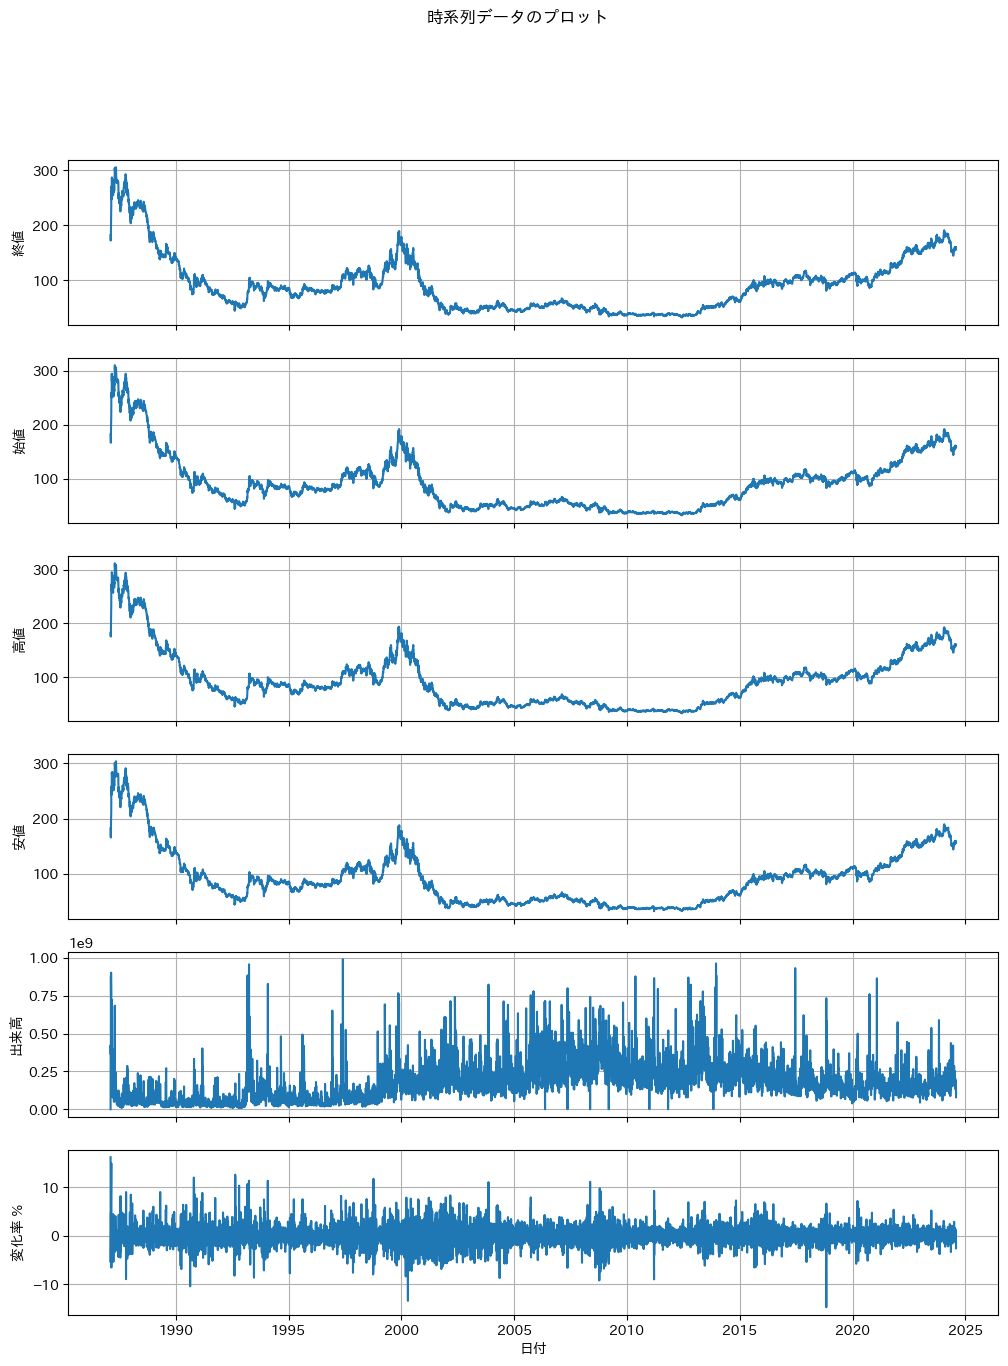

In [7]:
# 各時系列データを可視化
fig, axs = plt.subplots(6, 1, figsize=(12, 15), sharex=True)
fig.suptitle('時系列データのプロット')

columns = ['終値', '始値', '高値', '安値', '出来高', '変化率 %']
for i, col in enumerate(columns):
    axs[i].plot(df_2.index, df_2[col])
    axs[i].set_ylabel(col)
    axs[i].grid()

plt.xlabel('日付')
plt.show()

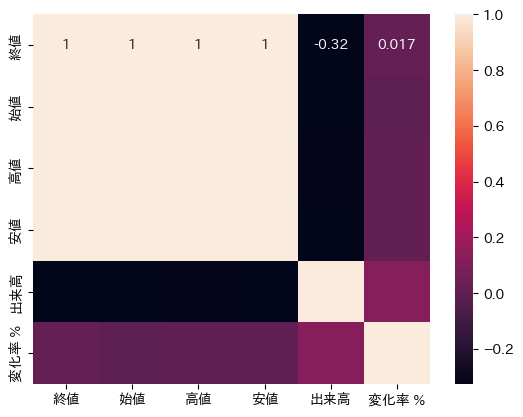

In [8]:
# 相関係数の可視化
correlation_matrix = df_2.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

c:\Users\chisa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chisa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chisa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chisa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

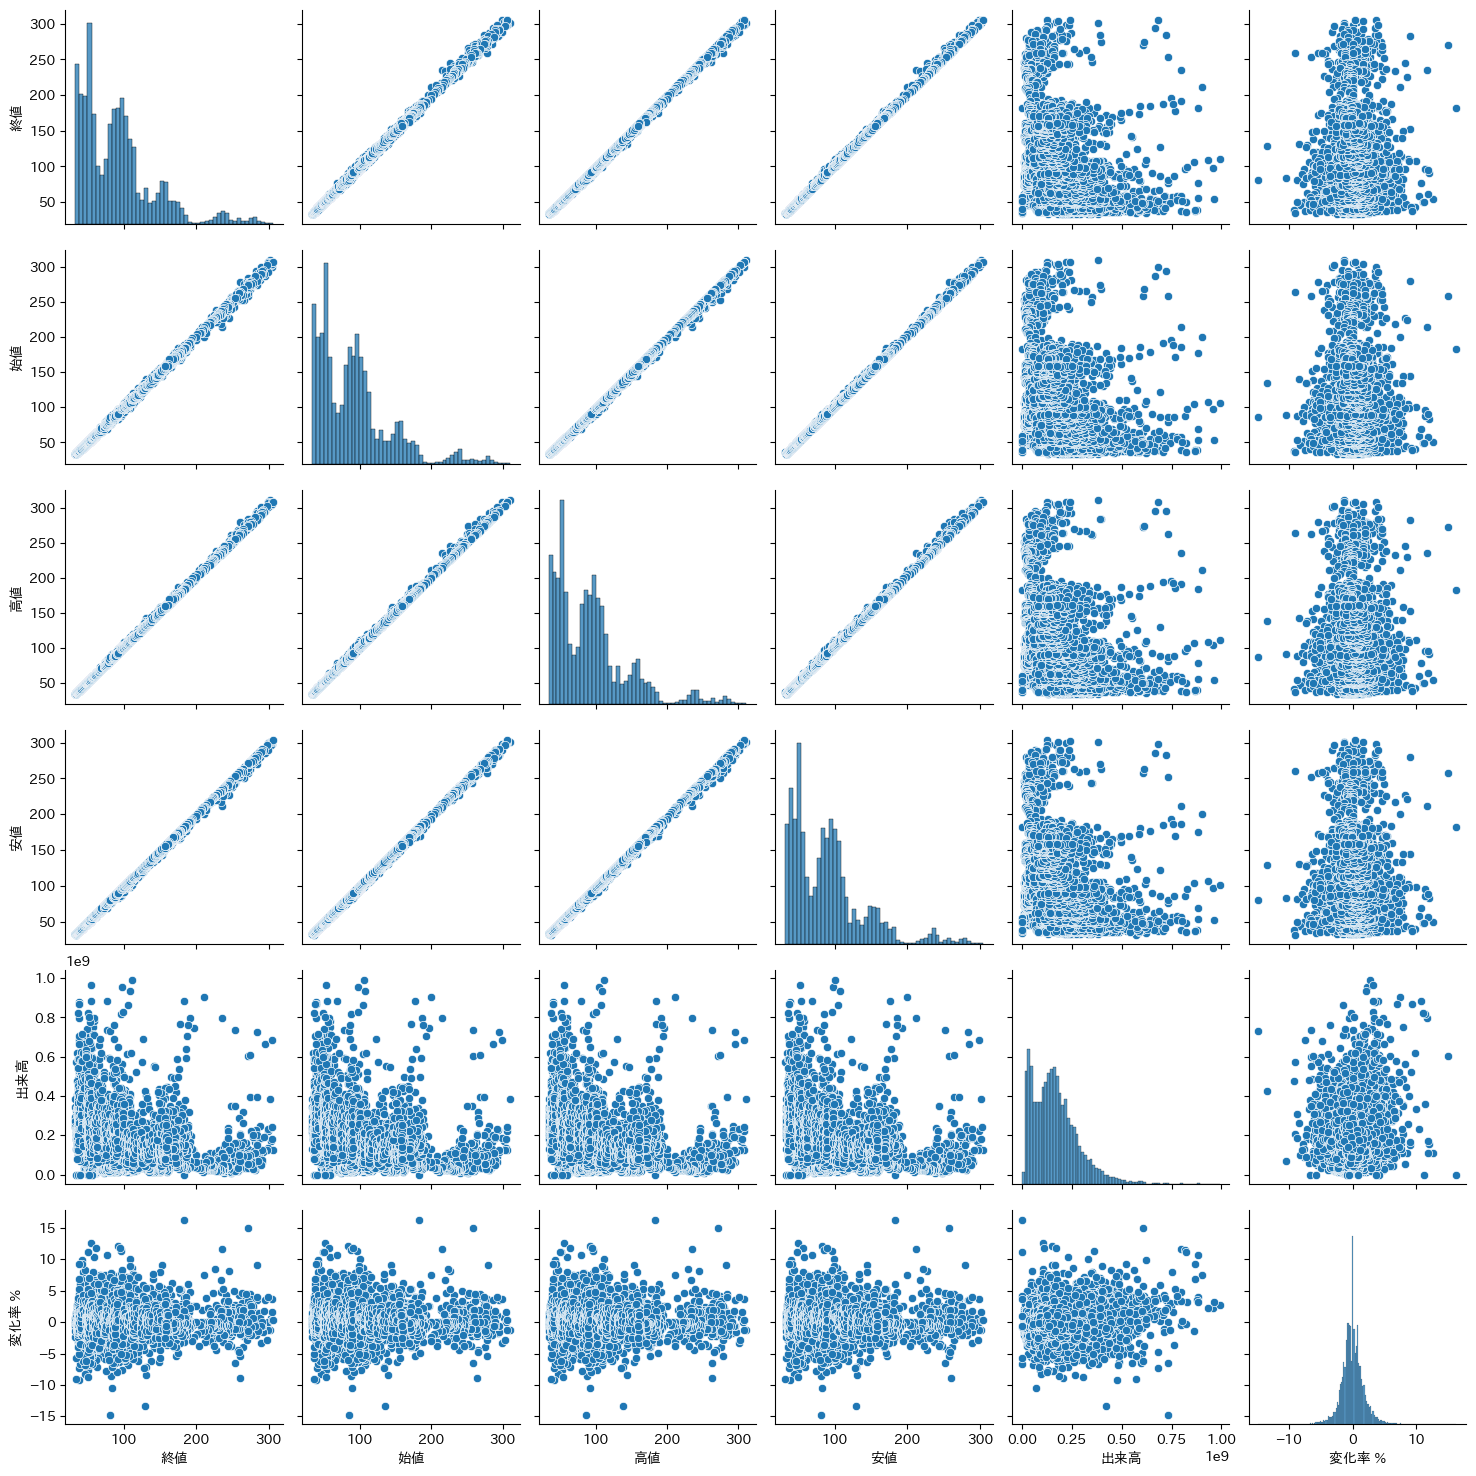

In [9]:
# 散布図、ヒストグラム
sns.pairplot(df_2)
plt.show()

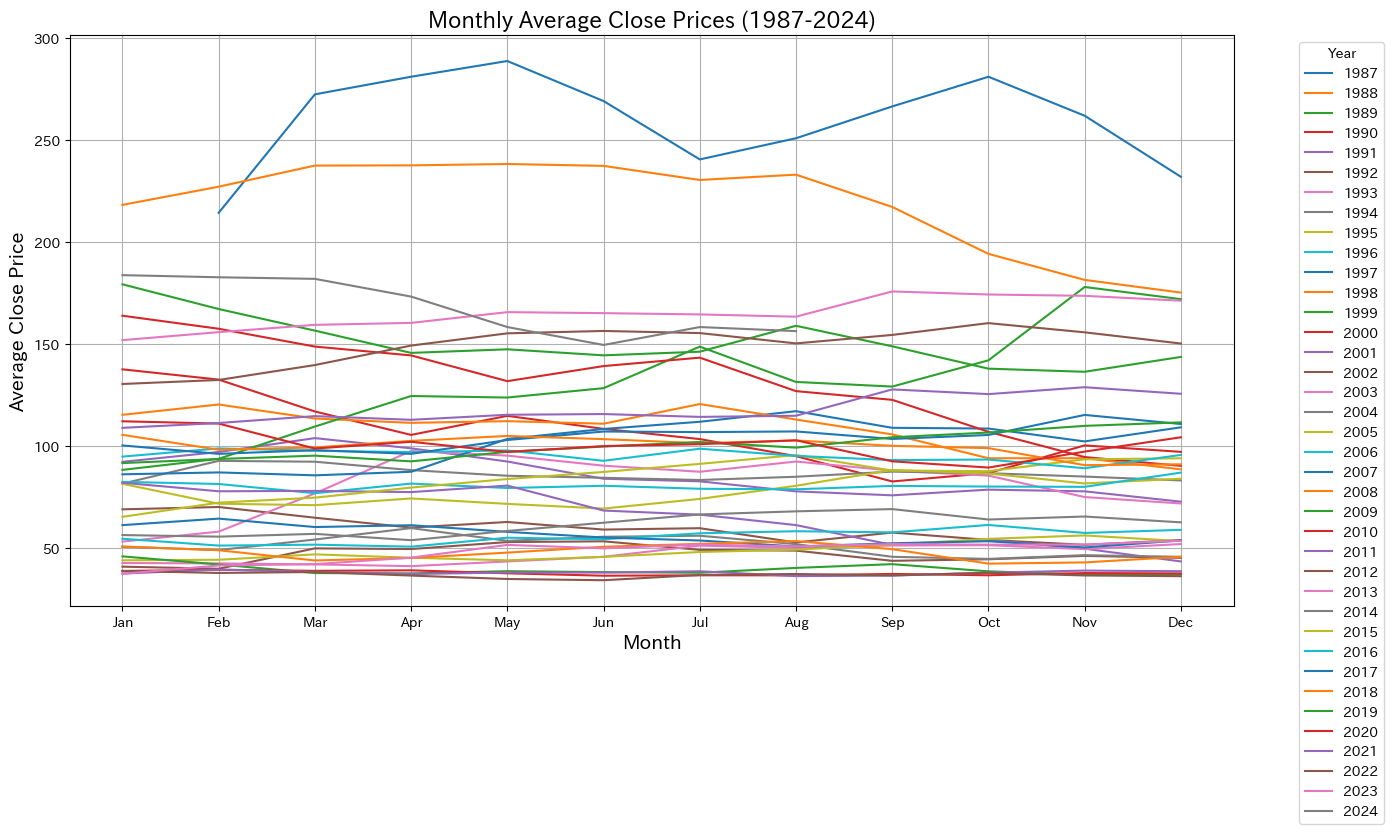

In [10]:
# インデックスから年と月を取得
df_3 = df_2.copy()
df_3['year'] = df_3.index.year
df_3['month'] = df_3.index.month

# 月ごとの終値の平均を計算
monthly_avg = df_3.groupby(['year', 'month'])['終値'].mean().reset_index()

# ピボットテーブルを作成（行: 月, 列: 年, 値: 平均終値）
pivot_data = monthly_avg.pivot(index='month', columns='year', values='終値')

# プロットの作成
plt.figure(figsize=(14, 8))
for year in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[year], label=str(year))

# グラフの設定
plt.title('Monthly Average Close Prices (1987-2024)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Close Price', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.grid()
plt.tight_layout()
plt.show()

#### 季節性・トレンドの確認

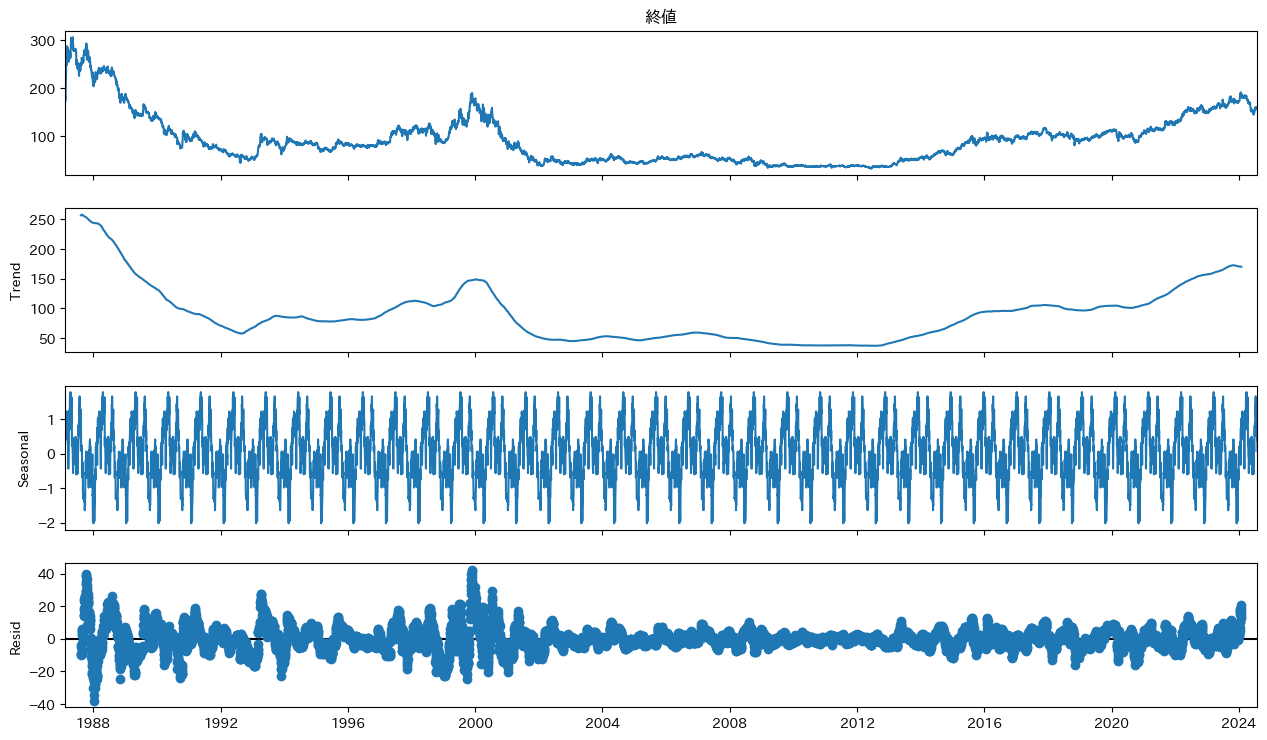

In [11]:
# 終値のトレンド・季節性・残差の分解
decomposition = seasonal_decompose(df_2["終値"], model='additive', period=252)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

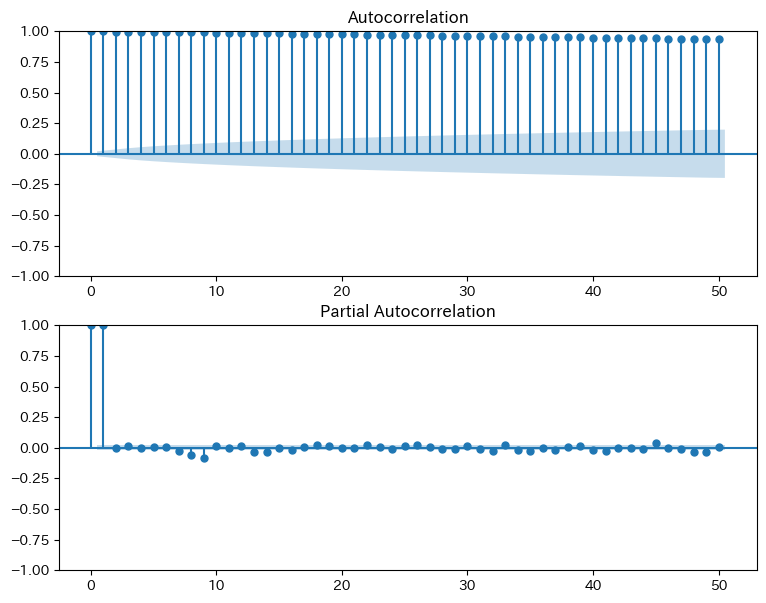

In [12]:
# 自己相関・偏自己相関の可視化
fig=plt.figure(figsize=(9, 7))

# 自己相関係数
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_2["終値"], lags=50, ax=ax1)

# 偏自己相関係数
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_2["終値"], lags=50, ax=ax2)

plt.show()

In [13]:
# 終値の列を抽出
closing_prices = df_2['安値']

# ADF検定の実行
adf_result = adfuller(closing_prices)

# 結果の出力
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

# p-valueの解釈
if adf_result[1] < 0.05:
    print("p-value < 0.05: 帰無仮説を棄却できます。この時系列は定常である可能性があります。")
else:
    print("p-value >= 0.05: 帰無仮説を棄却できません。この時系列は非定常である可能性があります。")

ADF Test Statistic: -3.0550074151347455
p-value: 0.03006702814794225
Critical Values: {'1%': -3.431063240789355, '5%': -2.861855206863889, '10%': -2.5669377795542005}
p-value < 0.05: 帰無仮説を棄却できます。この時系列は定常である可能性があります。


元データの標準偏差: 50.45222821917721
季節成分を取り除いたデータの標準偏差: 50.43741723859727


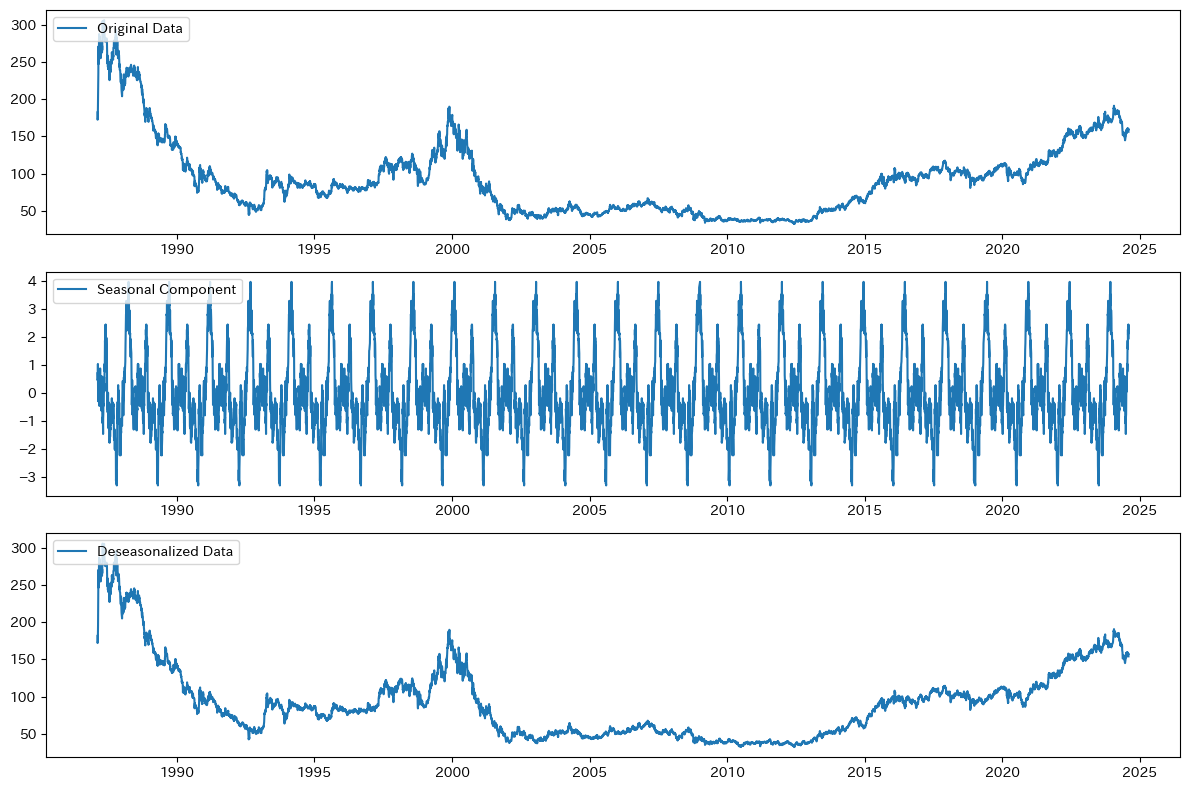

In [14]:
# 季節性分解
result = seasonal_decompose(df_2['終値'], model='additive', period=365)  # 30はおおよその周期（例として1か月）

# 季節成分を取り除いたデータ
detrended_data = df_2['終値'] - result.seasonal

# 標準偏差の計算
original_std = df_2['終値'].std()
deseasonalized_std = detrended_data.std()

# 結果を表示
print("元データの標準偏差:", original_std)
print("季節成分を取り除いたデータの標準偏差:", deseasonalized_std)

# プロットで確認
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(df_2['終値'], label='Original Data')
plt.legend(loc='upper left')

plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonal Component')
plt.legend(loc='upper left')

plt.subplot(3, 1, 3)
plt.plot(detrended_data, label='Deseasonalized Data')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### 外れ値の確認

In [15]:
def detect_stock_outliers(df, window=20, std_threshold=3):
    target_columns = ['終値', '始値', '高値', '安値', '出来高', '変化率 %']
    
    # 結果を格納するデータフレーム
    outliers_df = df.copy()
    
    # 各カラムの統計情報を格納する辞書
    stats = {}
    
    for column in target_columns:
        # 移動平均を計算
        rolling_mean = df[column].rolling(window=window, center=True).mean()
        
        # 移動標準偏差を計算
        rolling_std = df[column].rolling(window=window, center=True).std()
        
        # 移動平均からの乖離を標準偏差の倍数で判定
        deviation = abs(df[column] - rolling_mean)
        outliers = deviation > (std_threshold * rolling_std)
        
        # 外れ値フラグをデータフレームに追加
        outliers_df[f'{column}_is_outlier'] = outliers
        
        # 統計情報を記録
        stats[column] = {
            'total_outliers': outliers.sum(),
            'outlier_percentage': (outliers.sum() / len(df) * 100),
            'mean_value': df[column].mean(),
            'std_value': df[column].std(),
            'max_deviation': deviation.max(),
            'outlier_dates': df[outliers].index.tolist()
        }
        
        # 外れ値の詳細情報を追加
        outliers_df[f'{column}_deviation'] = deviation
        outliers_df[f'{column}_zscore'] = deviation / rolling_std
    
    return outliers_df, stats

def analyze_outliers(df, stats, max_dates=10):
    summary = "外れ値分析結果サマリー:\n\n"
    
    for column in stats.keys():
        # 外れ値の日付を年月日形式でフォーマット
        formatted_dates = [d.strftime('%Y-%m-%d') if hasattr(d, 'strftime') 
                         else str(d) 
                         for d in stats[column]['outlier_dates'][:max_dates]]
        
        summary += f"【{column}】\n"
        summary += f"- 検出された外れ値の数: {stats[column]['total_outliers']:,}件\n"
        summary += f"- データ全体に対する割合: {stats[column]['outlier_percentage']:.2f}%\n"
        summary += f"- 最大乖離値: {stats[column]['max_deviation']:.2f}\n"
        summary += f"- 代表的な外れ値の日付 (最初の{max_dates}件):\n"
        for date in formatted_dates:
            summary += f"    {date}\n"
        summary += "\n"
    
    return summary

df = df_2
outliers_df, stats = detect_stock_outliers(df, window=20, std_threshold=3)

# 分析結果の表示（最初の10件の日付を表示）
print(analyze_outliers(outliers_df, stats, max_dates=10))


外れ値分析結果サマリー:

【終値】
- 検出された外れ値の数: 1件
- データ全体に対する割合: 0.01%
- 最大乖離値: 23.61
- 代表的な外れ値の日付 (最初の10件):
    1989-06-29

【始値】
- 検出された外れ値の数: 1件
- データ全体に対する割合: 0.01%
- 最大乖離値: 33.86
- 代表的な外れ値の日付 (最初の10件):
    2016-07-21

【高値】
- 検出された外れ値の数: 0件
- データ全体に対する割合: 0.00%
- 最大乖離値: 29.52
- 代表的な外れ値の日付 (最初の10件):

【安値】
- 検出された外れ値の数: 2件
- データ全体に対する割合: 0.02%
- 最大乖離値: 27.76
- 代表的な外れ値の日付 (最初の10件):
    1988-05-02
    2021-06-21

【出来高】
- 検出された外れ値の数: 78件
- データ全体に対する割合: 0.85%
- 最大乖離値: 767556500.00
- 代表的な外れ値の日付 (最初の10件):
    1987-03-27
    1988-01-28
    1988-06-10
    1988-08-01
    1988-12-22
    1989-10-25
    1990-05-16
    1991-09-13
    1991-10-03
    1991-12-13

【変化率 %】
- 検出された外れ値の数: 35件
- データ全体に対する割合: 0.38%
- 最大乖離値: 14.18
- 代表的な外れ値の日付 (最初の10件):
    1987-07-23
    1988-09-27
    1989-02-23
    1989-04-25
    1990-06-20
    1990-08-23
    1991-05-01
    1991-10-03
    1992-07-02
    1992-10-23




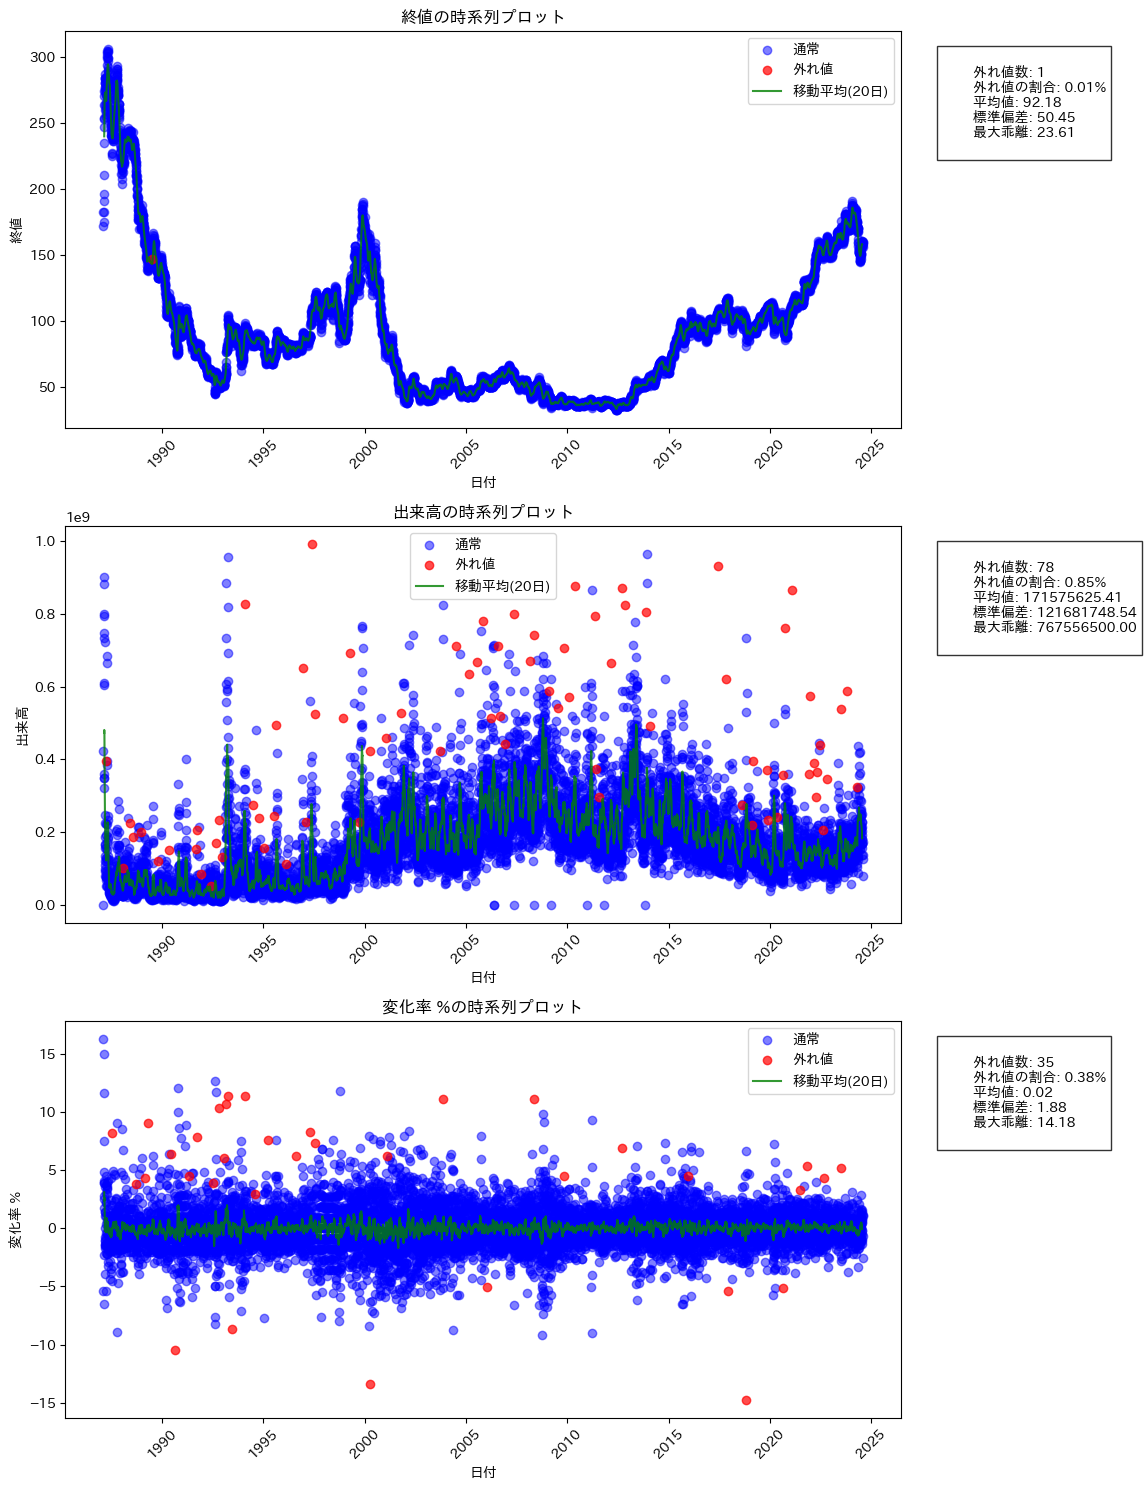

In [16]:
def plot_outliers(df, stats, column_names=['終値', '出来高', '変化率 %']):
    fig = plt.figure(figsize=(20, 5 * len(column_names)))
    
    for idx, column in enumerate(column_names):
        # 時系列散布図
        ax1 = plt.subplot(len(column_names), 2, 2*idx + 1)
        
        # 通常のデータをプロット
        normal_mask = ~df[f'{column}_is_outlier']
        ax1.scatter(df.index[normal_mask], 
                   df[column][normal_mask], 
                   c='blue', 
                   alpha=0.5, 
                   label='通常')


        # 外れ値をプロット
        outlier_mask = df[f'{column}_is_outlier']
        ax1.scatter(df.index[outlier_mask], 
                   df[column][outlier_mask], 
                   c='red', 
                   alpha=0.7, 
                   label='外れ値')
        
        # 移動平均線をプロット
        rolling_mean = df[column].rolling(window=20, center=True).mean()
        ax1.plot(df.index, rolling_mean, 'g-', label='移動平均(20日)', alpha=0.8)
        
        ax1.set_title(f'{column}の時系列プロット')
        ax1.set_xlabel('日付')
        ax1.set_ylabel(column)
        ax1.legend()
        ax1.tick_params(axis='x', rotation=45)

        
        
        # 統計情報を表示
        stats_text = f"""
        外れ値数: {stats[column]['total_outliers']}
        外れ値の割合: {stats[column]['outlier_percentage']:.2f}%
        平均値: {stats[column]['mean_value']:.2f}
        標準偏差: {stats[column]['std_value']:.2f}
        最大乖離: {stats[column]['max_deviation']:.2f}
        """
        ax1.text(1.05, 0.95, stats_text,
                transform=ax1.transAxes,
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='top')
    
    plt.tight_layout()
    return fig

df = df_2
outliers_df, stats = detect_stock_outliers(df)

# 可視化
fig = plot_outliers(outliers_df, stats)
plt.show()


### 3.前処理

#### 外れ値を移動平均で置換


出来高の処理結果:
置換された外れ値の数: 78
元データの平均: 171575625.41
処理後の平均: 169090219.76
元データの標準偏差: 121681748.54
処理後の標準偏差: 116929606.98

変化率 %の処理結果:
置換された外れ値の数: 35
元データの平均: 0.02
処理後の平均: 0.00
元データの標準偏差: 1.88
処理後の標準偏差: 1.81


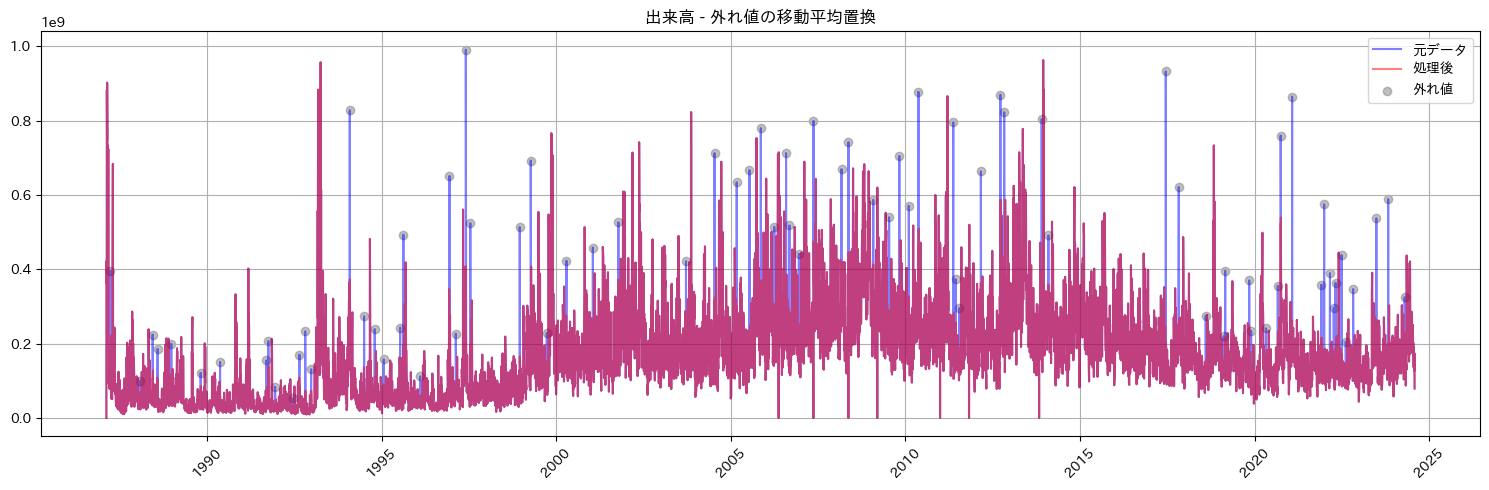

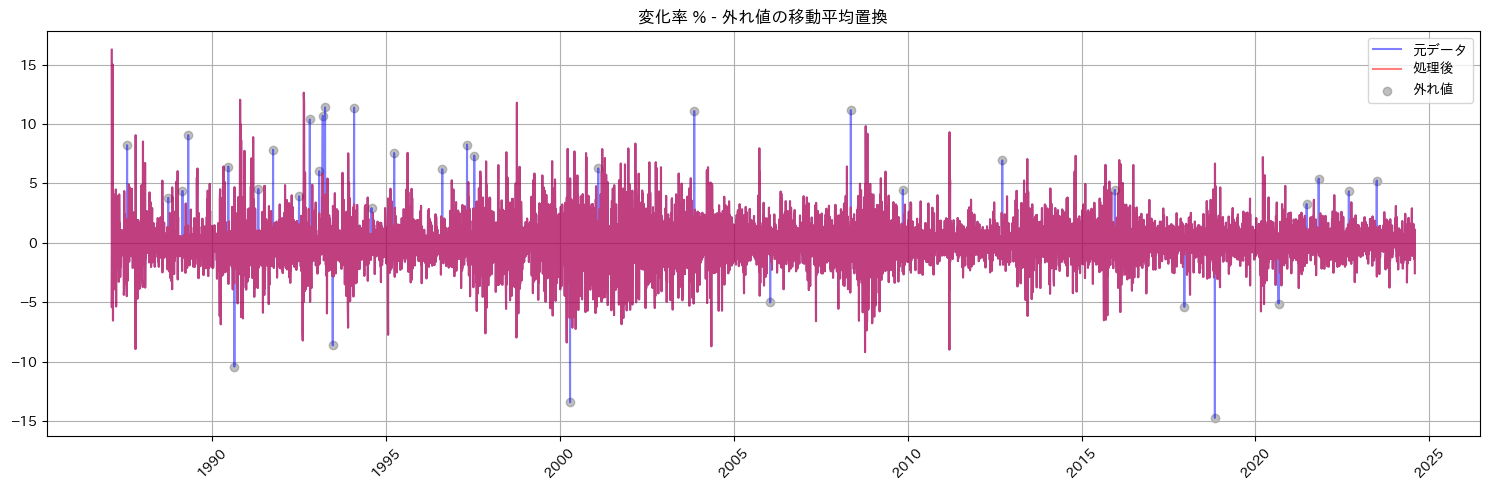

,終値,始値,高値,安値,出来高,変化率 %
日付け,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,128000.0,16.25
1987-02-13,172.5,176.5,176.5,172.5,422380000.0,-5.43
1987-02-16,175.5,166.7,175.5,165.7,360510000.0,1.74
1987-02-17,182.4,176.5,184.3,175.5,881510000.0,3.93
1987-02-18,191.2,186.3,191.2,186.3,795090000.0,4.82


In [17]:
# 外れ値を移動平均で置換
def replace_outliers_with_ma(df, outliers_df, target_columns=['終値', '始値', '安値', '出来高', '変化率 %'], window=20):
    processed_df = df.copy()
    
    # 置換の統計情報を格納する辞書
    replacement_stats = {}
    
    for column in target_columns:
        # 外れ値マスクの取得
        outlier_mask = outliers_df[f'{column}_is_outlier']
        
        # 移動平均の計算
        ma = df[column].rolling(window=window, center=True).mean()
        
        # 外れ値を移動平均で置換
        processed_df.loc[outlier_mask, column] = ma[outlier_mask]
        
        # 統計情報の記録
        replacement_stats[column] = {
            '置換された外れ値の数': outlier_mask.sum(),
            '元データの平均': df[column].mean(),
            '処理後の平均': processed_df[column].mean(),
            '元データの標準偏差': df[column].std(),
            '処理後の標準偏差': processed_df[column].std()
        }
    
    return processed_df, replacement_stats

# 外れ値の検出（前述のコードで実行済みと仮定）
outliers_df, stats = detect_stock_outliers(df_2, window=20, std_threshold=3)

# 外れ値を移動平均で置換
df_processed, replacement_stats = replace_outliers_with_ma(
    df=df_2,
    outliers_df=outliers_df,
    target_columns=['出来高', '変化率 %'],
    window=20
)

# 処理結果の確認
for column, stats in replacement_stats.items():
    print(f"\n{column}の処理結果:")
    for key, value in stats.items():
        if isinstance(value, (int, np.integer)):
            print(f"{key}: {value:,}")
        else:
            print(f"{key}: {value:.2f}")


for column in ['出来高', '変化率 %']:
    plt.figure(figsize=(15, 5))
    
    # 元データのプロット
    plt.plot(df_2.index, df_2[column], 'b-', alpha=0.5, label='元データ')
    
    # 処理後のデータのプロット
    plt.plot(df_processed.index, df_processed[column], 'r-', alpha=0.5, label='処理後')
    
    # 外れ値のポイントを表示
    outlier_mask = outliers_df[f'{column}_is_outlier']
    plt.scatter(df_2[outlier_mask].index, df_2[outlier_mask][column], 
                c='gray', alpha=0.5, label='外れ値')
    
    plt.title(f'{column} - 外れ値の移動平均置換')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 新しいデータフレーム
df_processed.head()

#### 特徴量エンジニアリング

In [18]:
# Volatility, Returnを追加
df_processed['Return'] = df_processed['終値'] - df_processed['始値']
df_processed['Volatility'] = df_processed['高値'] - df_processed['安値']

# テクニカル指標の追加
import ta
# RSI
df_processed['RSI'] = ta.momentum.RSIIndicator(df_processed['終値'], window=14).rsi()

# MACD
df_processed['MACD'] = ta.trend.MACD(df_processed['終値'], window_slow=26, window_fast=12, window_sign=9).macd()
df_processed['MACD_signal'] = ta.trend.MACD(df_processed['終値'], window_slow=26, window_fast=12, window_sign=9).macd_signal()
df_processed['MACD_histogram'] = df_processed['MACD'] - df_processed['MACD_signal']

df_sarima = df_processed[['終値', '始値', '高値', '安値', '出来高', '変化率 %', 'Return', 'Volatility', 'RSI', 'MACD_signal', 'MACD_histogram']]

# 差分
df_sarima['diff_close'] = df_sarima['終値'].diff(2)
df_sarima = df_sarima.dropna()  # 欠損値を削除


In [19]:
df_processed = df_processed[['終値', '始値', '高値', '安値', '出来高', '変化率 %', 'Return', 'Volatility', 'MACD',  'MACD_signal', 'MACD_histogram', 'RSI']]
df_processed


,終値,始値,高値,安値,出来高,変化率 %,Return,Volatility,MACD,MACD_signal,MACD_histogram,RSI
日付け,,,,,,,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,128000.0,16.25,0.0,0.0,NaN,NaN,NaN,NaN
1987-02-13,172.5,176.5,176.5,172.5,422380000.0,-5.43,-4.0,4.0,NaN,NaN,NaN,NaN
1987-02-16,175.5,166.7,175.5,165.7,360510000.0,1.74,8.8,9.8,NaN,NaN,NaN,NaN
1987-02-17,182.4,176.5,184.3,175.5,881510000.0,3.93,5.9,8.8,NaN,NaN,NaN,NaN
1987-02-18,191.2,186.3,191.2,186.3,795090000.0,4.82,4.9,4.9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,155080000.0,-0.13,-1.4,1.7,1.468375,1.514778,-0.046403,53.386642
2024-07-29,159.7,158.7,160.2,158.4,126280000.0,1.14,1.0,1.8,1.471290,1.506080,-0.034790,57.971702
2024-07-30,158.7,158.8,159.2,158.0,138140000.0,-0.63,-0.1,1.2,1.377035,1.480271,-0.103236,54.749681


### 4.終値予測モデル(SARIMAX)

Scaled_始値_diff    0
Scaled_高値_diff    0
Scaled_安値_diff    0
Scaled_出来高        0
Scaled_MACD       0
RSI               0
dtype: int64

モデルの構築を開始します...


c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: 6202.06

逆変換後のモデル評価結果:
Mean Squared Error: 31.3277
Root Mean Squared Error: 5.5971
Mean Absolute Error: 4.8529
R-squared Score: 0.9610


c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


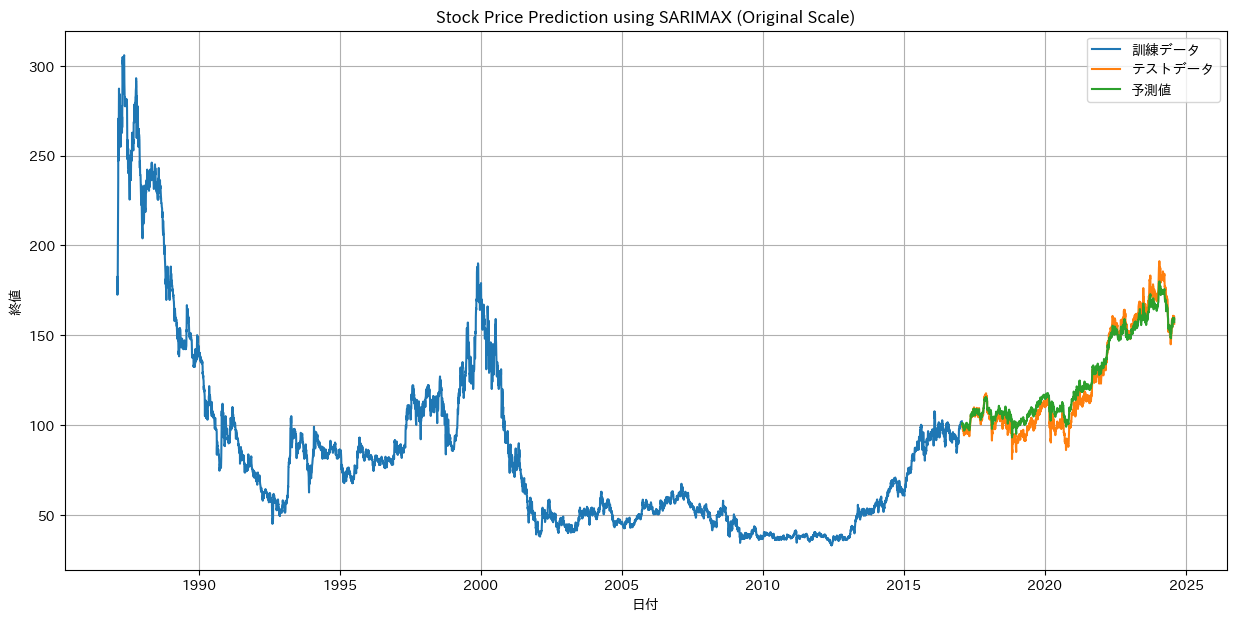

In [26]:
def prepare_scaled_data(df_processed, split_point):
    # 訓練データとテストデータの分割
    train_df = df_processed[:split_point].copy()
    test_df = df_processed[split_point:].copy()
    
    # 差分を取る変数（価格関連のみ）
    price_cols = ['終値', '始値', '高値', '安値']
    for col in price_cols:
        train_df[f'{col}_diff'] = train_df[col].diff(1).fillna(0)
        test_df[f'{col}_diff'] = test_df[col].diff(1).fillna(0)
    
    # スケーリング対象の列を定義
    diff_columns = [f'{col}_diff' for col in price_cols]
    direct_scale_columns = ['出来高', 'MACD', 'MACD_signal', 'MACD_histogram', 'Volatility']
    no_scale_columns = ['RSI']
    
    # train_df, test_dfからNaNを削除
    train_df = train_df.dropna()
    test_df = test_df.dropna()
    
    # StandardScalerの適用
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    
    # スケーリング
    columns_to_scale = diff_columns + direct_scale_columns
    scaler.fit(train_df[columns_to_scale])
    train_scaled_array = scaler.transform(train_df[columns_to_scale])
    test_scaled_array = scaler.transform(test_df[columns_to_scale])
    
    # DataFrameの作成
    scaled_columns = [f'Scaled_{col}' for col in columns_to_scale]
    train_scaled = pd.DataFrame(
        train_scaled_array,
        columns=scaled_columns,
        index=train_df.index
    )
    test_scaled = pd.DataFrame(
        test_scaled_array,
        columns=scaled_columns,
        index=test_df.index
    )
    
    # スケーリング不要な列の追加
    for col in no_scale_columns:
        train_scaled[col] = train_df[col]
        test_scaled[col] = test_df[col]
    
    return train_scaled, test_scaled, scaler

def build_sarimax_model(train_endog, test_endog, train_exog, test_exog):
    """
    SARIMAXモデルの構築と予測
    """
    model = SARIMAX(train_endog,
                    exog=train_exog,
                    order=(2, 0, 1),
                    seasonal_order=(1, 1, 1, 5),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    results = model.fit(disp=False)
    
    # AICの算出
    aic = results.aic
    print(f'\nAIC: {aic:.2f}')
    
    forecast = results.get_forecast(steps=len(test_endog), exog=test_exog)
    forecast_mean = forecast.predicted_mean
    
    return results, forecast_mean

def inverse_transform_predictions(predictions, train_ewm, train_vewm):
    """
    予測値の逆変換（訓練データの統計量を使用）
    """
    # 差分の逆変換
    cumsum_predictions = np.cumsum(predictions)
    
    # スケーリングの逆変換（訓練データの最後の統計量を使用）
    inverse_scaled = (cumsum_predictions * np.sqrt(train_vewm['終値'].iloc[-1]) + 
                     train_ewm['終値'].iloc[-1])
    
    return inverse_scaled

def evaluate_model(test_endog, predictions, df_original, train_ewm, train_vewm):
    """
    モデルの評価関数（訓練データの統計量を使用した逆変換後の評価）
    """
    # 予測値の逆変換
    inverse_predictions = inverse_transform_predictions(predictions, train_ewm, train_vewm)
    
    # 実際の値（テストデータ）
    actual_values = df_original['終値'].iloc[-len(predictions):]
    
    # 評価指標の計算
    mse = mean_squared_error(actual_values, inverse_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, inverse_predictions)
    r2 = r2_score(actual_values, inverse_predictions)
    
    print('\n逆変換後のモデル評価結果:')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R-squared Score: {r2:.4f}')
    
    return mse, rmse, mae, r2

def plot_results(train_endog, test_endog, predictions, df_original, train_ewm, train_vewm):
    """
    結果のプロット関数（訓練データの統計量を使用した逆変換後）
    """
    # 予測値の逆変換
    inverse_predictions = inverse_transform_predictions(predictions, train_ewm, train_vewm)
    
    plt.figure(figsize=(15, 7))
    plt.plot(df_original['終値'].index[:-len(test_endog)], 
             df_original['終値'].iloc[:-len(test_endog)], 
             label='訓練データ')
    plt.plot(df_original['終値'].index[-len(test_endog):], 
             df_original['終値'].iloc[-len(test_endog):], 
             label='テストデータ')
    plt.plot(df_original['終値'].index[-len(predictions):], 
             inverse_predictions, 
             label='予測値')
    plt.title('Stock Price Prediction using SARIMAX (Original Scale)')
    plt.xlabel('日付')
    plt.ylabel('終値')
    plt.legend()
    plt.grid(True)
    plt.show()

def main(df_processed):
    # データの分割ポイント
    split_point = int(len(df_processed) * 0.8)
    
    # 移動平均と移動分散の計算（逆変換用）
    train_ewm = df_processed[:split_point].ewm(span=10).mean()
    train_vewm = df_processed[:split_point].ewm(span=10).var()
    
    # スケーリングとデータ準備
    train_scaled, test_scaled, scaler = prepare_scaled_data(df_processed, split_point)
    

    
    # 目的変数と説明変数の設定
    target_col = 'Scaled_終値_diff'
    exog_cols = [
        'Scaled_始値_diff',
        'Scaled_高値_diff',
        'Scaled_安値_diff',
        'Scaled_出来高',
        'Scaled_MACD',
        'RSI'
    ]
    
    # データの準備
    train_endog = train_scaled[target_col]
    test_endog = test_scaled[target_col]
    train_exog = train_scaled[exog_cols]
    test_exog = test_scaled[exog_cols]
    
    # NaNがないか確認
    print(train_exog.isnull().sum())
    
    # モデルの構築と予測
    print("\nモデルの構築を開始します...")
    model_results, predictions = build_sarimax_model(
        train_endog, test_endog, train_exog, test_exog)
    
    # モデルの評価
    mse, rmse, mae, r2 = evaluate_model(test_endog, predictions, df_processed, train_ewm, train_vewm)
    
    # 結果のプロット
    plot_results(train_endog, test_endog, predictions, df_processed, train_ewm, train_vewm)
    
    return model_results, predictions, scaler, train_endog, test_endog, (mse, rmse, mae, r2)

# 実行
model_results, predictions, scaler, train_endog, test_endog, metrics = main(df_processed)


### 【検証】

データを分割中...
訓練データ数: 7333
テストデータ数: 1834

モデルを構築中...


c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



AIC: -5903.00

逆変換後のモデル評価結果:
Mean Squared Error: 69927.4978
Root Mean Squared Error: 264.4381
Mean Absolute Error: 234.0948
R-squared Score: -85.8504


c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chisa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


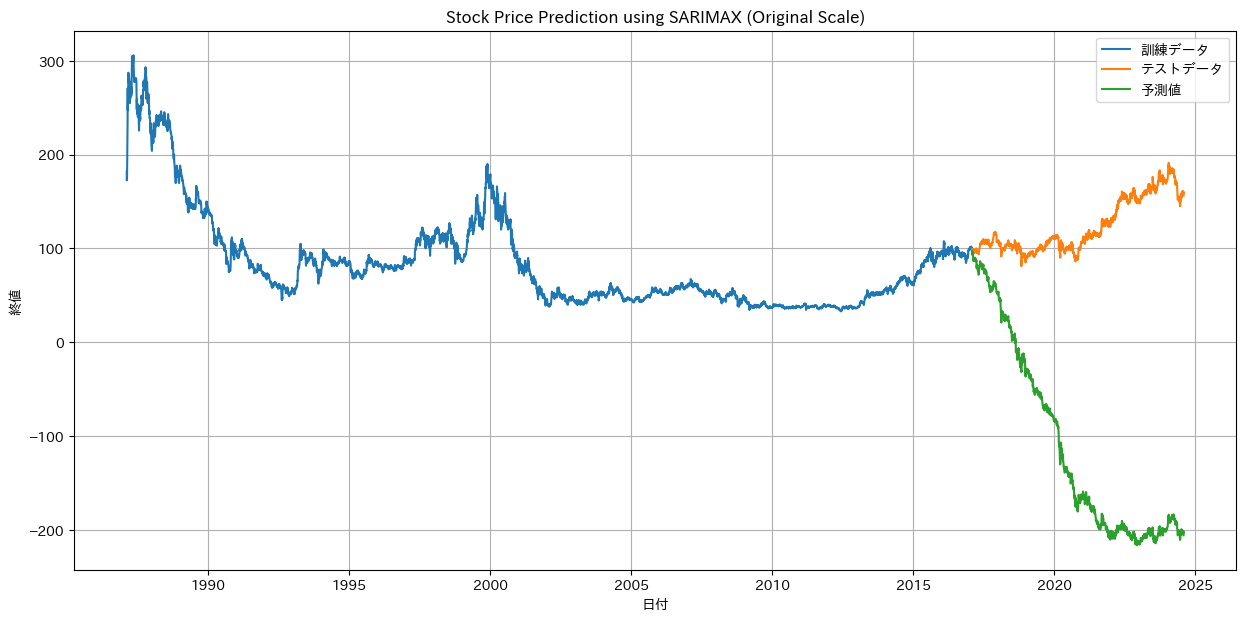

In [ ]:
def prepare_data(df, target_col, exog_cols):
    """
    データの分割関数
    df: データフレーム
    target_col: 目的変数のカラム名
    exog_cols: 説明変数のカラム名リスト
    """
    # データの分割
    split_point = int(len(df) * 0.8)
    train_endog = df.iloc[:split_point][target_col]
    test_endog = df.iloc[split_point:][target_col]
    train_exog = df.iloc[:split_point][exog_cols]
    test_exog = df.iloc[split_point:][exog_cols]
    
    return train_endog, test_endog, train_exog, test_exog

def prepare_scaled_data(df_processed, split_point):
    """
    訓練データとテストデータを適切に分割してスケーリング
    """
    # 訓練データとテストデータの分割
    train_df = df_processed[:split_point].copy()
    test_df = df_processed[split_point:].copy()
    
    # 訓練データのみでewmを計算
    train_ewm = train_df.ewm(halflife=10).mean()
    train_vewm = train_df.ewm(halflife=10).var()
    
    # スケーリング対象の列
    columns_to_scale = ['終値', '始値', '高値', '安値', '出来高', '変化率 %', 
                       'Return', 'Volatility', 'MACD', 'MACD_signal', 'MACD_histogram']
    
    # 訓練データのスケーリング
    train_scaled = train_df.copy()
    for col in columns_to_scale:
        train_scaled[f'Scaled{col}'] = ((train_df[col] - train_ewm[col]) / 
                                       (train_vewm[col]**0.5))
    
    # テストデータのスケーリング（訓練データの統計量を使用）
    test_scaled = test_df.copy()
    for col in columns_to_scale:
        test_scaled[f'Scaled{col}'] = ((test_df[col] - train_ewm[col].iloc[-1]) / 
                                      (train_vewm[col].iloc[-1]**0.5))
    
    # スケーリング後の差分を計算
    train_scaled['Scaled終値'] = train_scaled['Scaled終値'].diff(1)
    test_scaled['Scaled終値'] = test_scaled['Scaled終値'].diff(1)
    
    # 必要な列の選択
    columns_to_keep = ['Scaled終値', 'Scaled始値', 'Scaled高値', 'Scaled安値', 
                      'Scaled出来高', 'Scaled変化率 %', 'ScaledReturn', 
                      'ScaledVolatility', 'ScaledMACD', 'ScaledMACD_signal', 
                      'ScaledMACD_histogram', 'RSI']
    
    train_final = train_scaled[columns_to_keep].dropna()
    test_final = test_scaled[columns_to_keep].dropna()
    
    return train_final, test_final, train_ewm, train_vewm

def inverse_transform_predictions(predictions, train_ewm, train_vewm):
    """
    予測値の逆変換（訓練データの統計量を使用）
    """
    # 差分の逆変換
    cumsum_predictions = np.cumsum(predictions)
    
    # スケーリングの逆変換（訓練データの最後の統計量を使用）
    inverse_scaled = (cumsum_predictions * np.sqrt(train_vewm['終値'].iloc[-1]) + 
                     train_ewm['終値'].iloc[-1])
    
    return inverse_scaled

def evaluate_model(test_endog, predictions, df_original, train_ewm, train_vewm):
    """
    モデルの評価関数（訓練データの統計量を使用した逆変換後の評価）
    """
    # 予測値の逆変換
    inverse_predictions = inverse_transform_predictions(predictions, train_ewm, train_vewm)
    
    # 実際の値（テストデータ）
    actual_values = df_original['終値'].iloc[-len(predictions):]
    
    # 評価指標の計算
    mse = mean_squared_error(actual_values, inverse_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, inverse_predictions)
    r2 = r2_score(actual_values, inverse_predictions)
    
    print('\n逆変換後のモデル評価結果:')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R-squared Score: {r2:.4f}')
    
    return mse, rmse, mae, r2

def plot_results(train_endog, test_endog, predictions, df_original, train_ewm, train_vewm):
    """
    結果のプロット関数（訓練データの統計量を使用した逆変換後）
    """
    # 予測値の逆変換
    inverse_predictions = inverse_transform_predictions(predictions, train_ewm, train_vewm)
    
    plt.figure(figsize=(15, 7))
    plt.plot(df_original['終値'].index[:-len(test_endog)], 
             df_original['終値'].iloc[:-len(test_endog)], 
             label='訓練データ')
    plt.plot(df_original['終値'].index[-len(test_endog):], 
             df_original['終値'].iloc[-len(test_endog):], 
             label='テストデータ')
    plt.plot(df_original['終値'].index[-len(predictions):], 
             inverse_predictions, 
             label='予測値')
    plt.title('Stock Price Prediction using SARIMAX (Original Scale)')
    plt.xlabel('日付')
    plt.ylabel('終値')
    plt.legend()
    plt.grid(True)
    plt.show()

def main(df_processed):
    # データの分割ポイント
    split_point = int(len(df_processed) * 0.8)
    
    # スケーリングとデータ準備
    train_scaled, test_scaled, train_ewm, train_vewm = prepare_scaled_data(df_processed, split_point)
    
    # カラム名の指定
    target_col = 'Scaled終値'
    exog_cols = ['Scaled始値', 'Scaled高値', 'Scaled安値', 'Scaled出来高', 'Scaled変化率 %', 
                 'ScaledReturn', 'ScaledVolatility', 'ScaledMACD', 'ScaledMACD_signal', 
                 'ScaledMACD_histogram']

    # データの準備
    print('データを分割中...')
    train_endog, test_endog, train_exog, test_exog = prepare_data(
        pd.concat([train_scaled, test_scaled]), target_col, exog_cols)
    print(f'訓練データ数: {len(train_endog)}')
    print(f'テストデータ数: {len(test_endog)}')
    
    # モデルの構築と予測
    print('\nモデルを構築中...')
    model_results, predictions = build_sarimax_model(train_endog, test_endog, train_exog, test_exog)
    
    # モデルの評価（逆変換後）
    evaluation_metrics = evaluate_model(test_endog, predictions, df_processed, train_ewm, train_vewm)
    
    # 結果のプロット（逆変換後）
    plot_results(train_endog, test_endog, predictions, df_processed, train_ewm, train_vewm)
    
    return model_results, predictions, train_endog, test_endog

# 実行
model_results, predictions, train_endog, test_endog = main(df_processed)